# COVID-19 Simulation

This notebook contains an implementation of the SIR model, which was developed in 1927 by Kermack and McKendrick to model the spreading of epidemics.

The implementation here is roughly calibrated to the current situation in Germany (as of 27.3.2020). It is illustrates the effects of social distancing in achieving the objective of keeping the strain on the health care system as small as possible.

The SIR model is illustrated below using a stock and flow diagram:

![Image](images/sir_model.png)

__Assumptions:__

- Contact Rate: 20 persons. Defines how many people a person encounters per day in average.
- Infectivity: 2%. Defines the probability that a person becomes infected after contact with an infectious person.
- Intensive Care Needed: 0.2%. Measures the number of infected people who need intensive care.
- Intensive Care Available: 30,000 units. The number of intensive care units available.

## System Dynamics Model

The SIR model is implemented in System Dynamics using the [BPTK-Py](http://bptk.transentis-labs.com) framework.

First we need to setup the model class. We let the model run over 1500 days with a time step `dt`of one day.

In [2]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=1500.0,dt=1.0,name='sir')

### Stocks

Next we set up the stocks. We start with an inital value of 80 Mio. people for the `susceptible`stock (i.e. roughly the German population) and assume we have 120 infected people.

In [3]:
susceptible = model.stock("susceptible")
infectious = model.stock("infectious")
recovered = model.stock("recovered")
deceased = model.stock("deceased")

In [4]:
susceptible.initial_value = 80000000.0
infectious.initial_value = 120.0
recovered.initial_value = 0.0
deceased.initial_value = 0.0

### Flows

In [5]:
infection_rate = model.flow("infection_rate")
recovery_rate = model.flow("recovery_rate")
death_rate = model.flow("death_rate")

### Converters

In [6]:
contact_rate = model.converter("contact_rate")
total_population = model.converter("total_population")
net_population = model.converter("net_population")
intensive_needed = model.converter("intensive_needed")
intensive_rate = model.constant("intensive_rate")
infectivity = model.constant("infectivity")
intensive_available = model.constant("intensive_available")
lethality = model.constant("lethality")
average_duration = model.constant("average_duration")

### Equations

The settings for infectivity, lethality and the contact rate are the key settings that determine how quickly the epidemic spreads within the population.

We had to make some educated guesses here, as the true infectivity and lethality are currenty not known.

So we started with the assumtion that each person has 20 contacts per day on average (under normal circumstances, i.e without social distancing) and calibrated the model to the initial development in Germany. This resulted in the assumption of an invectivity of 0.02.

We assume it takes 20 days to recover from the virus and that the lethality is 0.001

In [7]:
susceptible.equation = -infection_rate
infectious.equation = infection_rate - recovery_rate - death_rate
recovered.equation = recovery_rate
deceased.equation = death_rate

In [8]:
infectivity.equation = 0.02
intensive_rate.equation = 0.002
intensive_available.equation = 30000.0
lethality.equation = 0.001
average_duration.equation = 20.0

In [9]:
contact_rate.equation = 20.0 
total_population.equation = susceptible+infectious+recovered
net_population.equation = total_population-deceased
intensive_needed.equation =infectious*intensive_rate

In [10]:
infection_rate.equation = (contact_rate*susceptible*infectivity)*(infectious/total_population)
recovery_rate.equation = infectious/average_duration
death_rate.equation = infectious*lethality

## Simulation Dashboard

In [11]:
import BPTK_Py
import pandas as pd
bptk = BPTK_Py.bptk()
bptk.register_model(model)

In [12]:
bptk.register_scenarios(
    scenarios ={
        "contactLargeGroups": {},
        "contactSmallGroups": {},
        "contactTwoPeople": {},
        "dashboard":{}
    },
    scenario_manager="smSir")

In [13]:
%run src/dashboard/sir_dashboard.ipy

GridBox(children=(IntSlider(value=0, continuous_update=False, description='Visualization Period Begin', layout…

## Scenarios

### Base Case

The base case describes the numbers in Germany and demonstrates what will happen if no measures are taken.

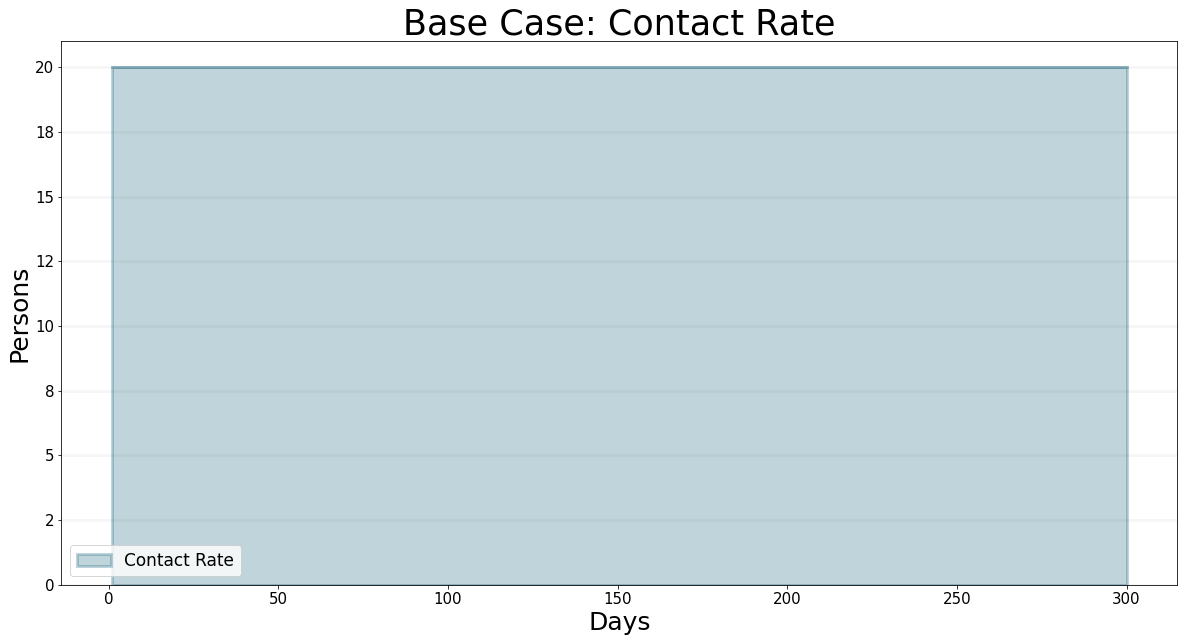

In [16]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    visualize_to_period=300,
    series_names={
        "smSir_base_contact_rate" : "Contact Rate"
    }
)

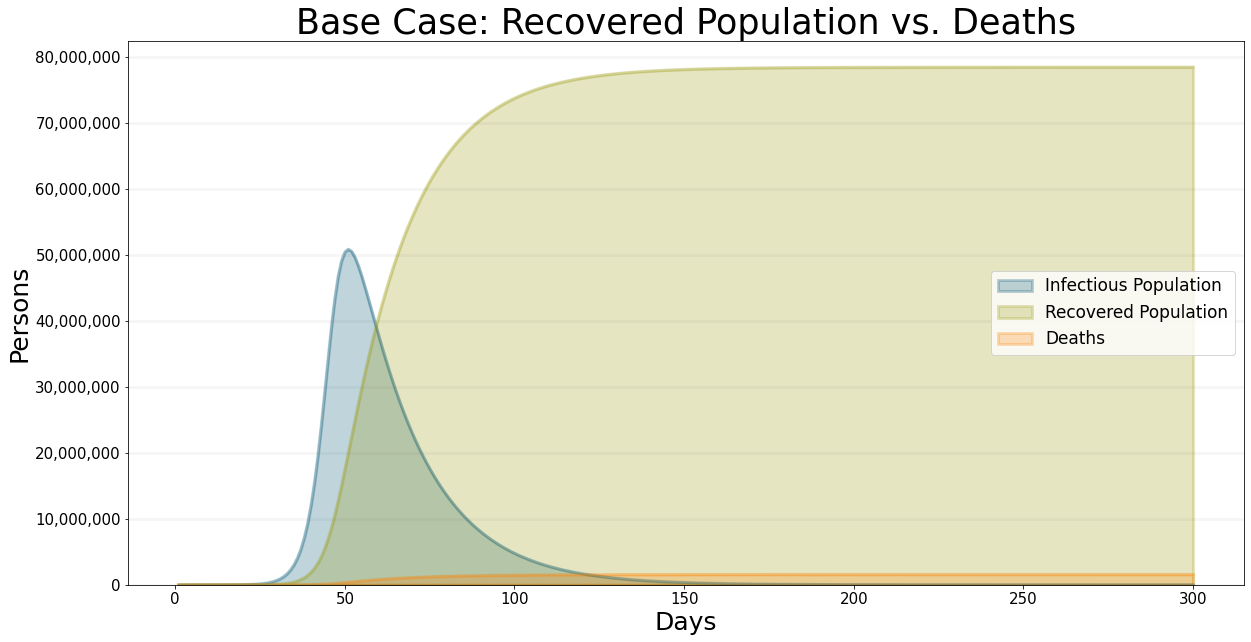

In [17]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    visualize_to_period=300,
    series_names={
        "smSir_base_infectious" : "Infectious Population",
        "smSir_base_recovered" : "Recovered Population",
        "smSir_base_deceased": "Deaths"
    }
)

Without any measures the numbers lead to explosive exponential growth as shown in the graph above. The graph below zooms in on the first 25 days - the exponential growth is already visible and the numbers match the situation in Germany well.

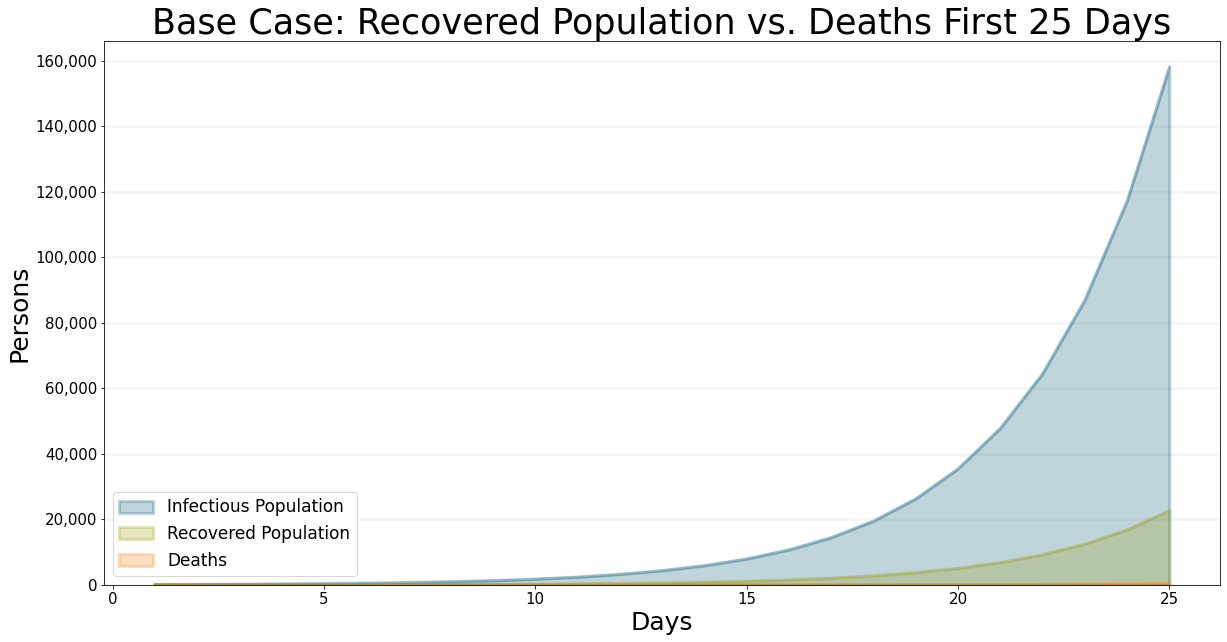

In [18]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths First 25 Days",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_base_infectious" : "Infectious Population",
        "smSir_base_recovered" : "Recovered Population",
        "smSir_base_deceased": "Deaths"
    },
    visualize_from_period=0,
    visualize_to_period=25
)

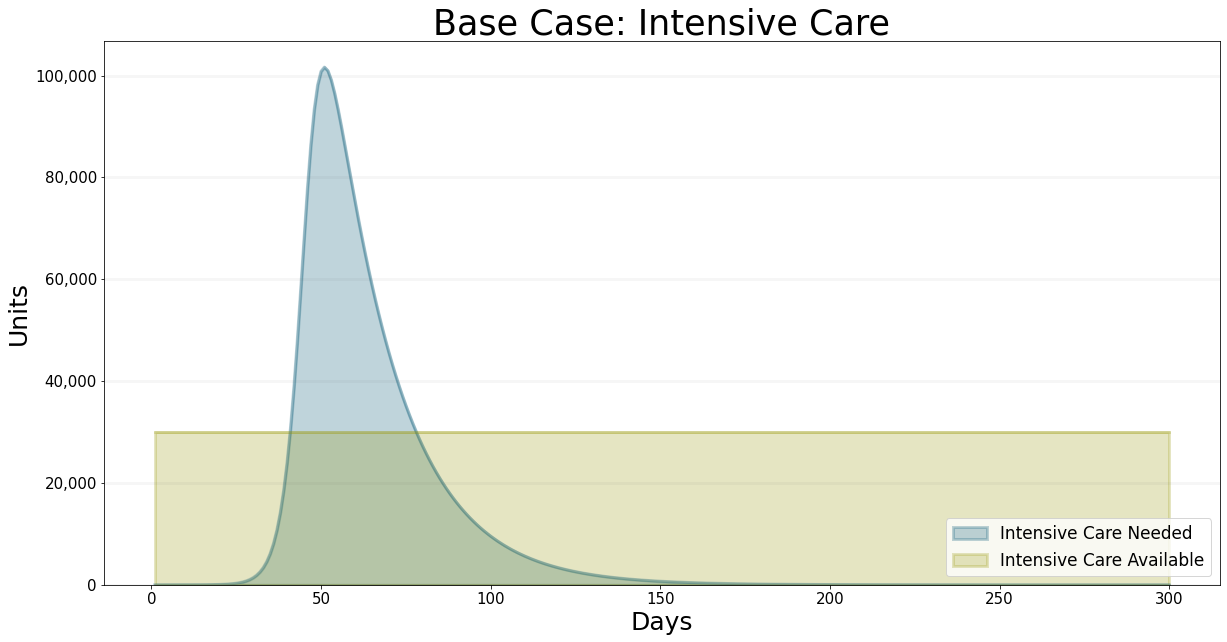

In [20]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_base_intensive_needed" : "Intensive Care Needed",
        "smSir_base_intensive_available" : "Intensive Care Available"  
    },
    visualize_to_period=300
)

The simulation also illustrates that there are not enough intensive care units available if the epidemic is left to grow without countermeasures.

### Reducing Spreading of the Virus

The following scenarios show the effect of taking measures. It shows which measures are necessary to avoid the collapse of the health care system.

#### Less contact to other people

We can avoid the spreading of the virus by reducing the contact to other people. In other words, we need to reduce the contact rate. Therefore less people can be infected.

In [24]:
from BPTK_Py.sdcompiler.sdmodel import LERP
contact_rate = int(bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['base'].model.equations['contact_rate'](0))

In [25]:
model_large_groups = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactLargeGroups'].model
stoptime_large_groups = int(model_large_groups.stoptime)

points_list_large = []
contact_large = contact_rate
for t in range(stoptime_large_groups):
    if t%40==0 and t!=0 and t < 365:
        contact_large = contact_large - 2
    if t == 600:
        contact_large = 6
    if t == 700:
        contact_large = 10
    if t == 800:
        contact_large = 14
    if t == 900:
        contact_large = 20
    points_list_large.append((t,contact_large))


model_large_groups.points["contactPointsLarge"] = points_list_large
model_large_groups.equations["contact_rate"] = lambda t: LERP(t,model_large_groups.points["contactPointsLarge"])

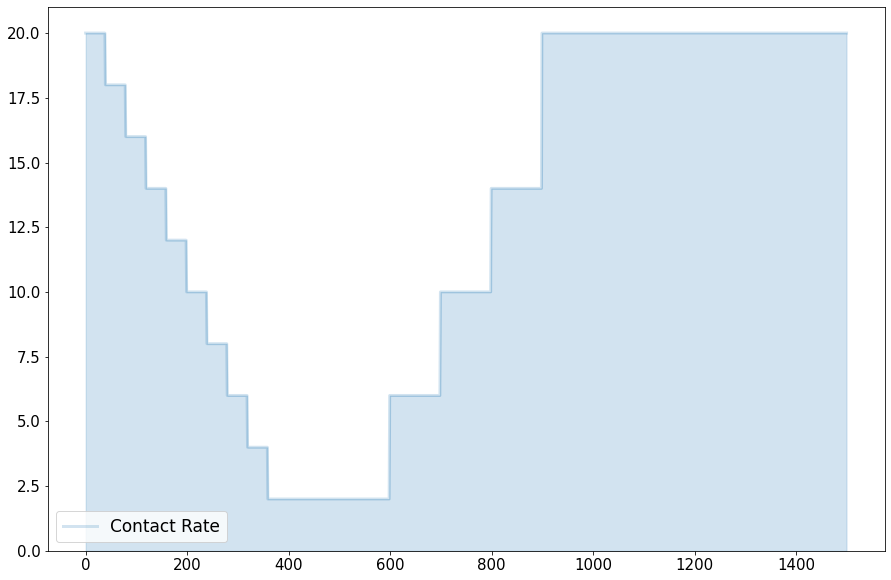

In [26]:
ax = pd.DataFrame([model_large_groups.equations["contact_rate"](t) for t in range(int(model_large_groups.starttime),int(model_large_groups.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

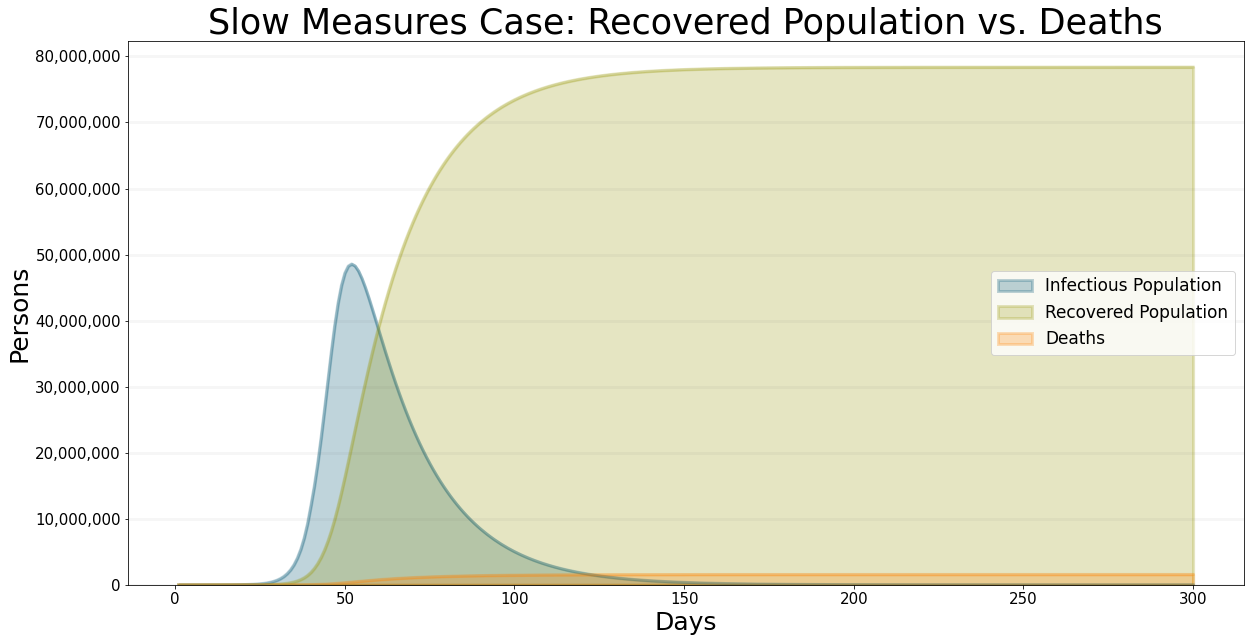

In [27]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_contactLargeGroups_infectious" : "Infectious Population",
        "smSir_contactLargeGroups_recovered" : "Recovered Population",
        "smSir_contactLargeGroups_deceased": "Deaths"
    },
    visualize_to_period=300
)

As you can see from the graph above, the number of the infectious population is still growing exponentially. Comparing the base scenario with this slow measures scenario, we can see that there is no siginificant difference. Taking measures too cautiously doesn't stop the spreading of the virus.

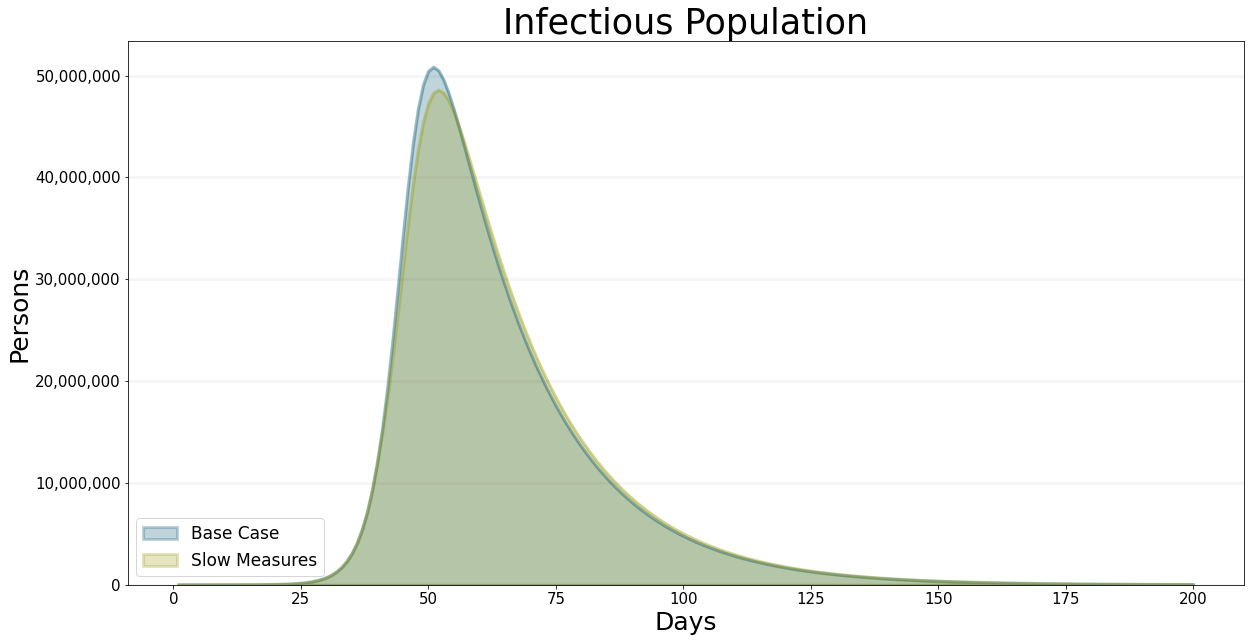

In [28]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["infectious"],
    series_names={
        "smSir_base_infectious" : "Base Case",
        "smSir_contactLargeGroups_infectious" : "Slow Measures"
    },
    visualize_to_period=200
    
)

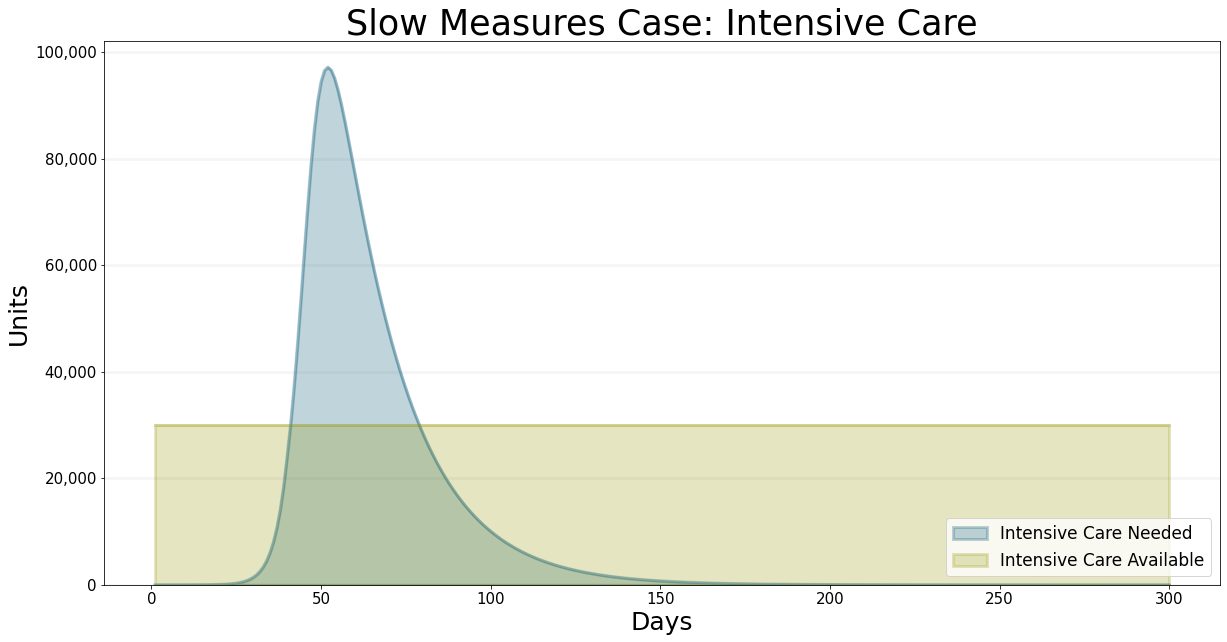

In [29]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_contactLargeGroups_intensive_needed" : "Intensive Care Needed",
        "smSir_contactLargeGroups_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

#### Strong Social Distancing

In [30]:
model_small_groups = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactSmallGroups'].model
stoptime_small_groups = model_small_groups.stoptime

points_list_small = []
contact_small = contact_rate
for t in range(int(stoptime_small_groups)):
    if t==25:
        contact_small= 10
    if t==41:
        contact_small = 5
    if t==500:
        contact_small = 10
    if t==1200:
        contact_small = 20
    points_list_small.append((t,contact_small))


model_small_groups.points["contactPointsSmall"] = points_list_small
model_small_groups.equations["contact_rate"] = lambda t: LERP(t,model_small_groups.points["contactPointsSmall"])

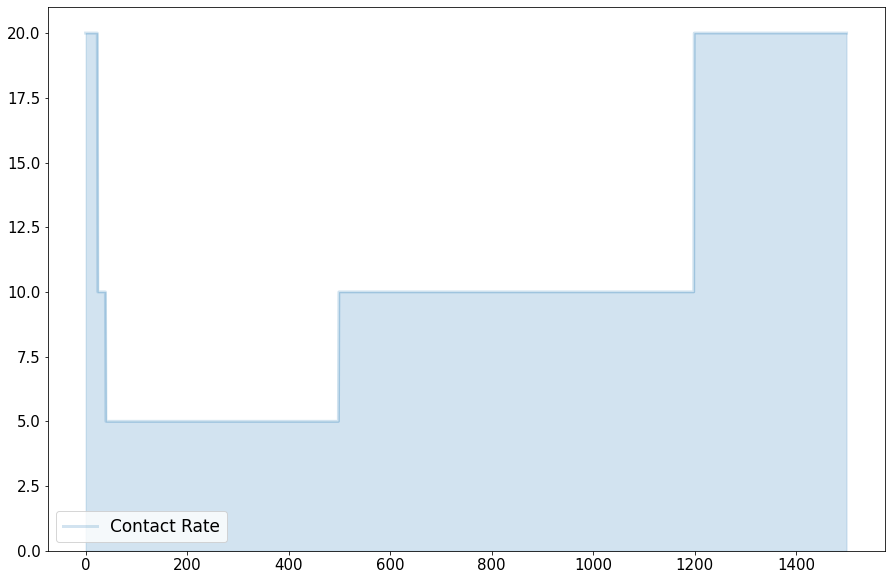

In [31]:
ax = pd.DataFrame([model_small_groups.equations["contact_rate"](t) for t in range(int(model_small_groups.starttime),int(model_small_groups.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

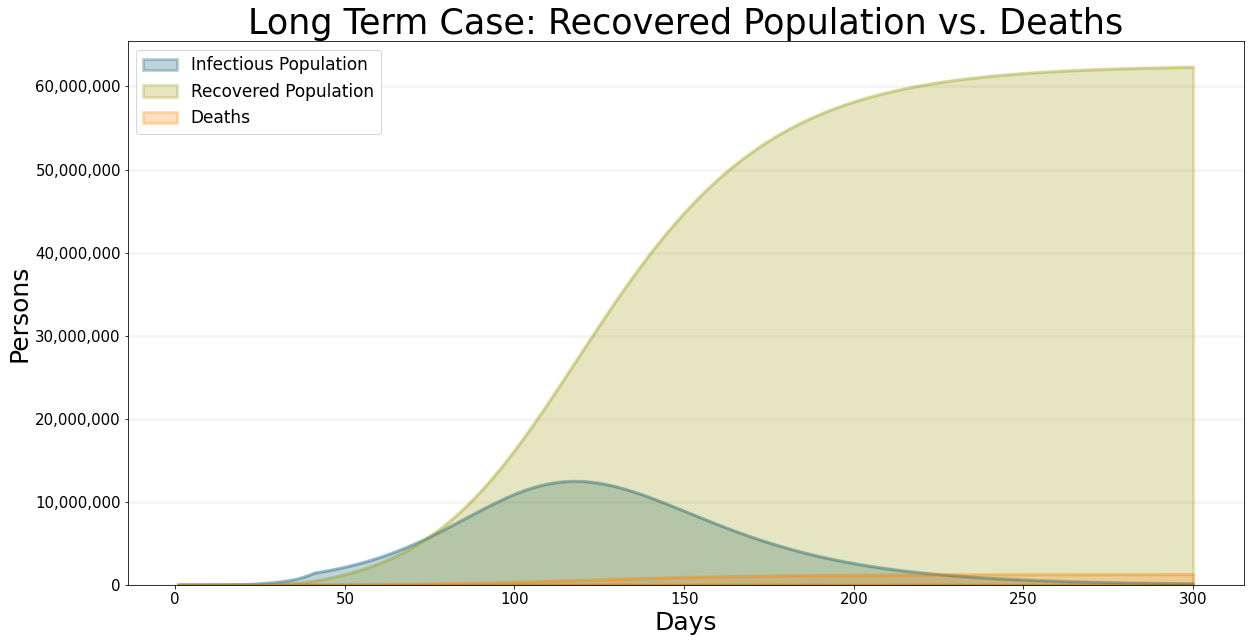

In [32]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_contactSmallGroups_infectious" : "Infectious Population",
        "smSir_contactSmallGroups_recovered" : "Recovered Population",
        "smSir_contactSmallGroups_deceased": "Deaths"
    },
    visualize_to_period=300
)

The graph shows that the strict measures help to reduce the spreading of the virus. The infectious population does not grow exponentially.

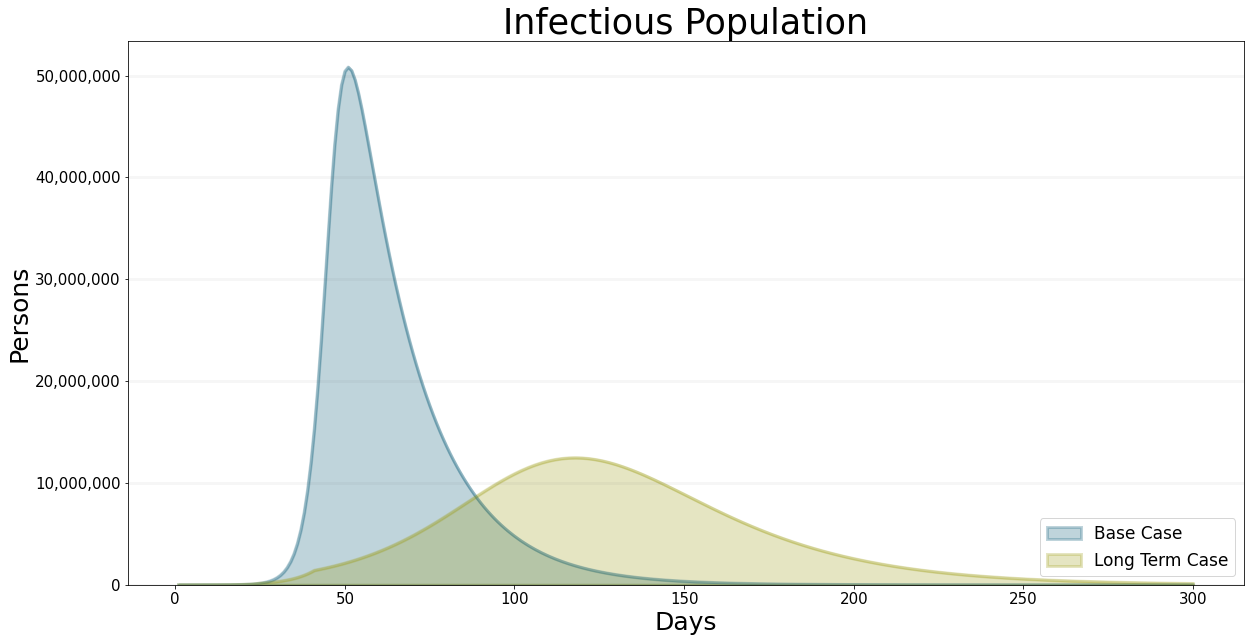

In [33]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["infectious"],
    series_names={
        "smSir_base_infectious" : "Base Case",
        "smSir_contactSmallGroups_infectious" : "Long Term Case"
    },
    visualize_to_period=300
    
)

Comparing this scenario with the base scenario we can see how important social distancing is.

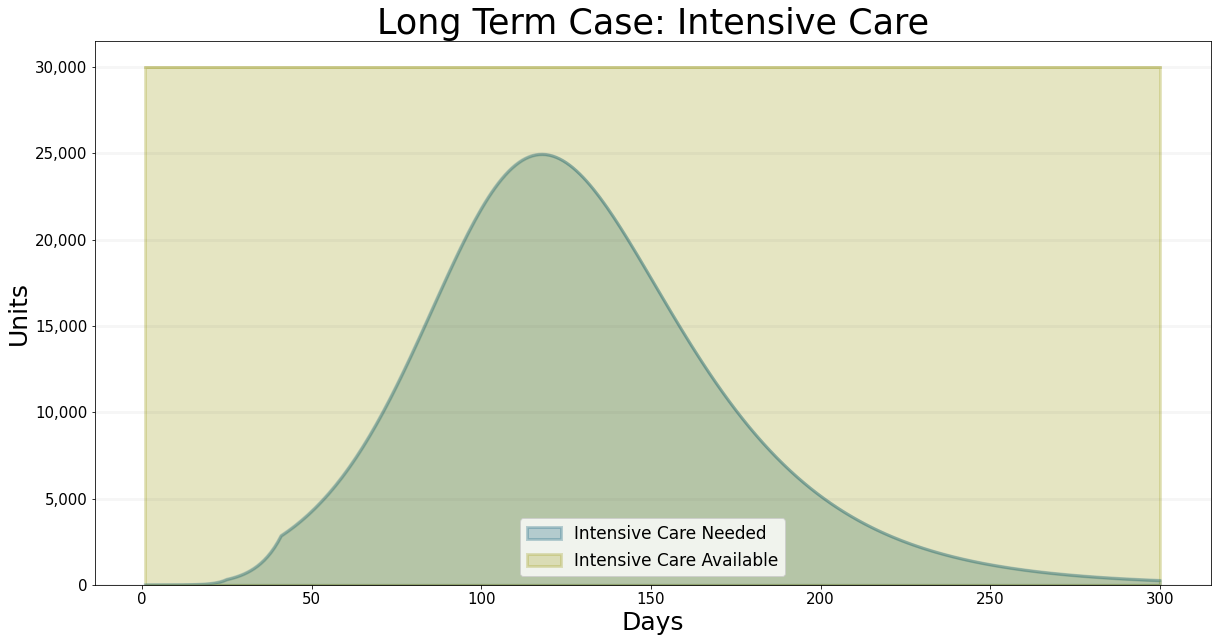

In [34]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["intensive_needed","intensive_available"],
    series_names={
        "smSir_contactSmallGroups_intensive_needed" : "Intensive Care Needed",
        "smSir_contactSmallGroups_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

For this scenario there are enough intensive care units available. A collapse of the heath care system won't happen.

#### Reducing contact rate from large groups to two people for only a short period of time

This scenario shows if taking measures radically but loosening them only after a short period of time to avoid the spreading of the virus. We reduce the contact rate to 2 after ten days and increase the contact rate 90 days later to 20.

### Reducing contact rate from large groups to two people for only a short period of time

In [35]:
model_two_people = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactTwoPeople'].model
stoptime_two_people = model_two_people.stoptime

points_list_two = []
contact_two = contact_rate
for t in range(int(stoptime_two_people)):
    if t==10:
        contact_two = 2
    if t==100:
        contact_two = 20
    points_list_two.append((t,contact_two))


model_two_people.points["contactPointsTwo"] = points_list_two
model_two_people.equations["contact_rate"] = lambda t: LERP(t,model_two_people.points["contactPointsTwo"])

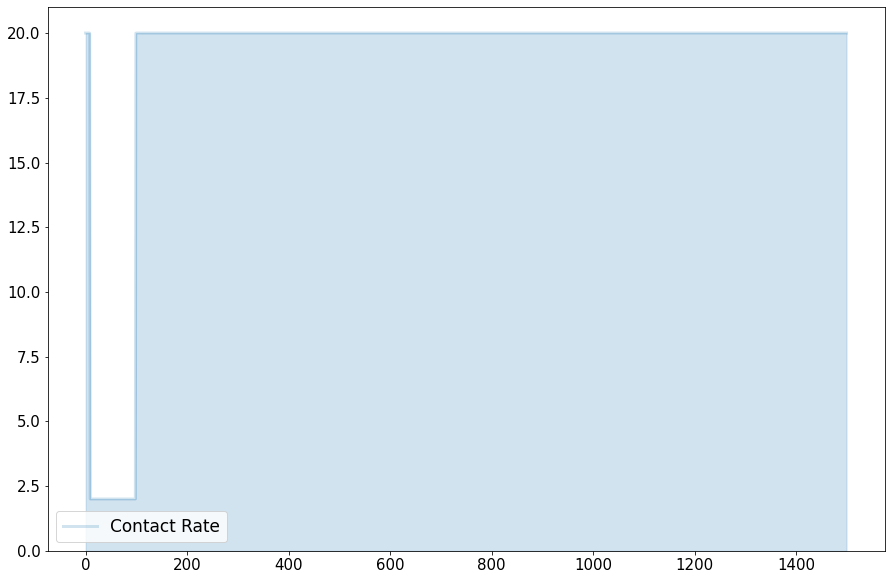

In [36]:
ax = pd.DataFrame([model_two_people.equations["contact_rate"](t) for t in range(int(model_two_people.starttime),int(model_two_people.stoptime+1))]).plot(kind="area",alpha=0.2,figsize=(15,10))
ax.legend(["Contact Rate"])

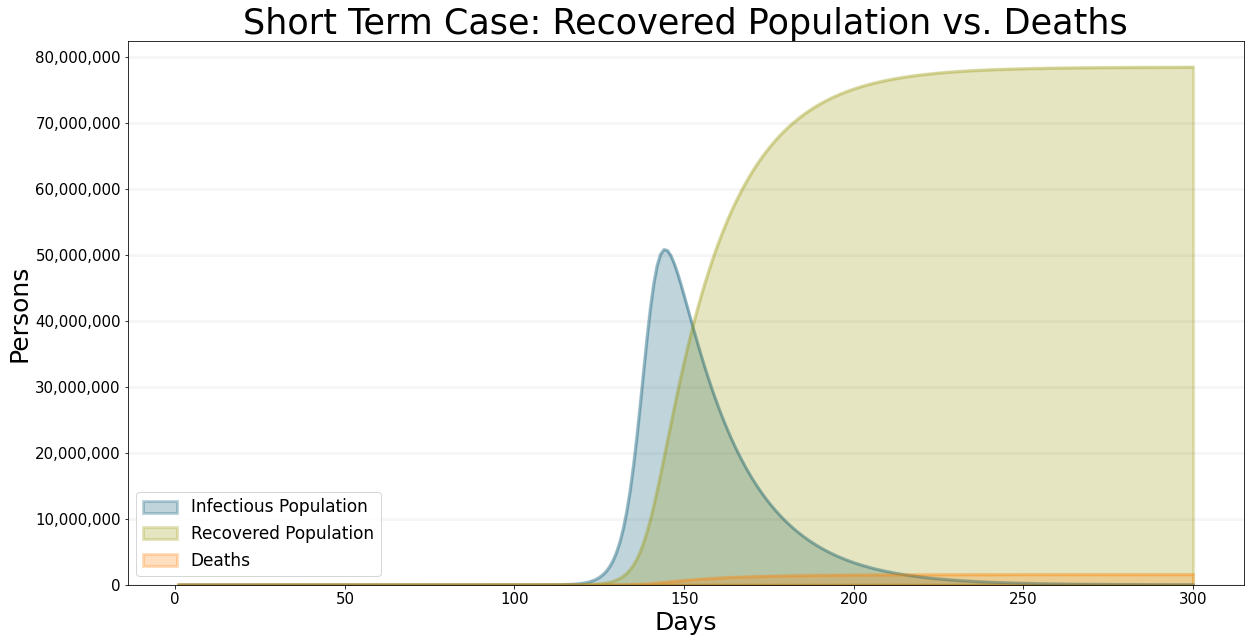

In [37]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["infectious","recovered","deceased"],
    series_names={
        "smSir_contactTwoPeople_infectious" : "Infectious Population",
        "smSir_contactTwoPeople_recovered" : "Recovered Population",
        "smSir_contactTwoPeople_deceased": "Deaths"
    },
    visualize_to_period=300
)

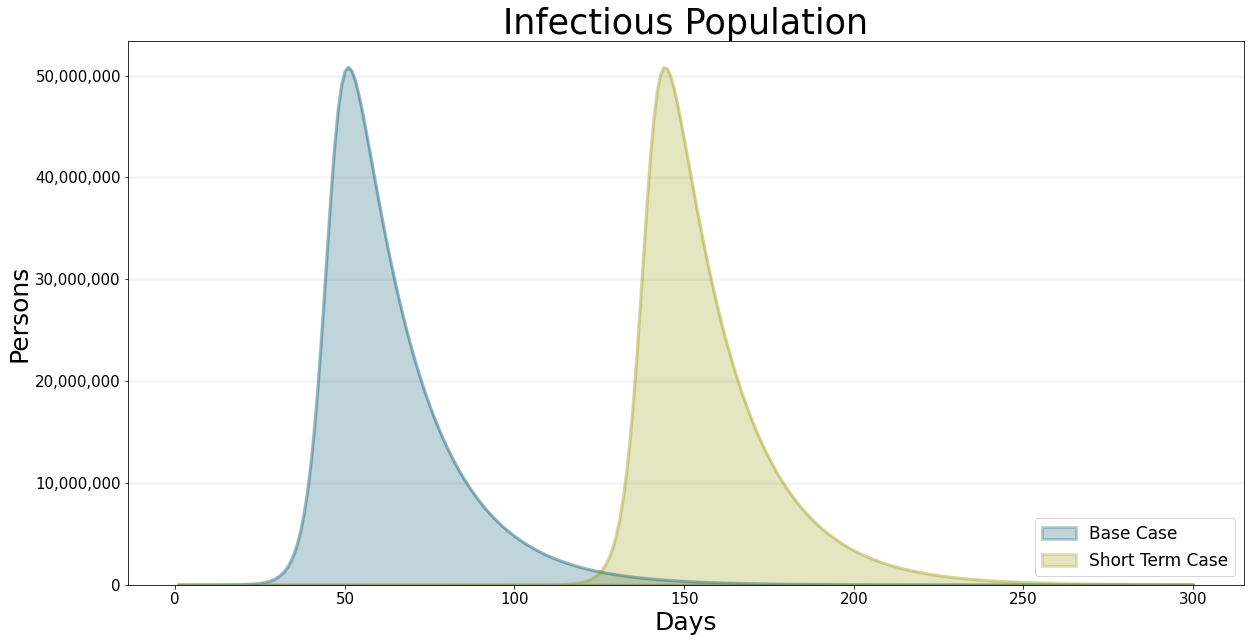

In [38]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["infectious"],
    series_names={
        "smSir_base_infectious" : "Base Case",
        "smSir_contactTwoPeople_infectious" : "Short Term Case"
    },
    visualize_to_period=300
    
)

Comparing this scenario with the base scenario shows that the problem is shifted to a later point in time. This means taking measures for only a short period of time won't stem the virus. 

2021-07-12 11:34:26.928845, [ERROR] No simulation model containing equation "insentive_needed". Did you maybe mean one of "intensive_needed, intensive_rate, infection_rate"?


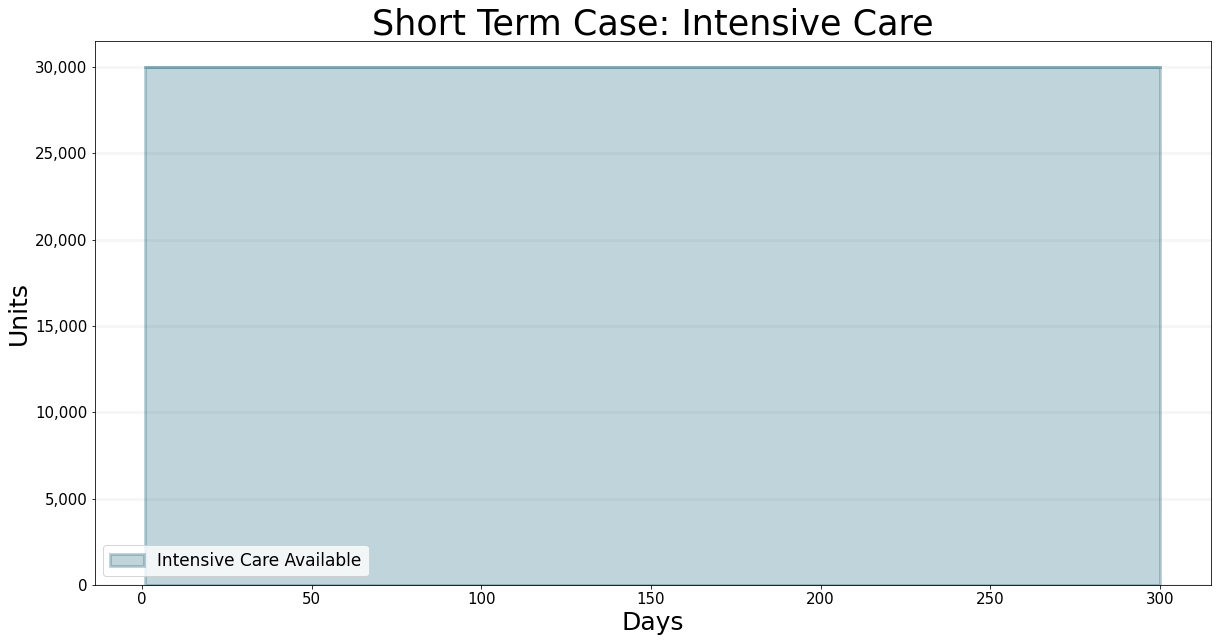

In [40]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["insentive_needed","intensive_available"],
    series_names={
        "smSir_contactTwoPeople_intensive_needed" : "Intensive Care Needed",
        "smSir_contactTwoPeople_intensive_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

As expected, there are not enough intensive care units but only at a later point of time.

## Summary

Though this is actually quite a simple model with only few parameters, we can already simulate some interesting aspects of the COVID-19 pandemic:

* The behaviour over the first 25 days fits nicely with the situation in Germany
* If no measures are taken, we will experience expontential growth of COVID-19 cases in a very short period of time
* Implementing harsh social distancing methods leads to the desired result of keeping the number of COVID-19 cases low and not putting to much strain on the health care system.
* Unfortunately the social distancing measures have to be kept up for quite some time in order to have an effect.
